# Hierarchical Regression
This notebook applies random forests as regressors to do Geology things!

In [126]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

## Base Functions
These are the basic functions used the implement that actual learning

In [127]:
def load_data(data_file, cols_to_use, target, categorical_cols = [],
    test_ratio = 0.2, normalisation="none"):
    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
    df = pd.read_csv(data_file, header=0)

    # keep only the columns in cols_to_use
    keep = cols_to_use + [target]
    df = df[keep]

    # separate target and data
    y = df[target]
    del df[target]
    X = df

    # one-hot code categorical variables
    numeric_columns = cols_to_use - categorical_cols
    X_num = X[numeric_columns]
    enc = OneHotEncoder(handle_unknown='ignore')
    X_cat = enc.fit_transform(X[categorical_cols])
    X = pd.concat([X_num, X_cat])

    # Make a train-test split
    X, y = shuffle(X, y, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)

    # Normalise data
    if normalisation == "minmax":
        norm_func_train = lambda x: (x - X_train[numeric_columns].min()) / (X_train[numeric_columns].max() - X_train[numeric_columns].min())
        norm_func_test = lambda x: (x - X_test[numeric_columns].min()) / (X_test[numeric_columns].max() - X_test[numeric_columns].min())
    elif normalisation == "zscore":
        norm_func_train = lambda x: (x - X_train[numeric_columns].mean()) / X_train[numeric_columns].std()
        norm_func_test = lambda x: (x - X_test[numeric_columns].mean()) / X_test[numeric_columns].std()
    elif normalisation == "none":
        norm_func_train = lambda x: x
        norm_func_test = lambda x: x
    else:
        raise ValueError("invalid normalisation: " + normalisation)

    X_train = norm_func_train(X_train)
    X_test = norm_func_test(X_test)

    return X_train, X_test, y_train, y_test, X, y

def cross_validate_depth(values, fold, X, y, **kwargs):
    X = X.to_numpy()
    y = y.to_numpy()
    kf = KFold(n_splits=fold, shuffle=True)
    mean_errors = np.array([])
    std_errors = np.array([])

    for value in values:
        model = RandomForestRegressor(max_depth=value, **kwargs).fit(X, y)
        MSEs = np.array([])
        for train, test in kf.split(X):
            model.fit(X[train], y[train])
            ypred = model.predict(X[test])
            MSEs = np.append(MSEs, mean_squared_error(y[test], ypred))
            
        # MSEs = np.array(MSEs)
        mean_errors = np.append(mean_errors, MSEs.mean())
        std_errors = np.append(std_errors, MSEs.std())

    return mean_errors, std_errors

def plot_cross_validation(values, value_name, mean_errors, std_errors, title):
    '''
    Creates a plot of the data from cross-=validation, with error bars
    '''
    plt.rc('font', size=18)
    plt.rcParams['figure.constrained_layout.use'] = True
    plt.errorbar(values, mean_errors, yerr=std_errors, linewidth=1)
    plt.xlabel(value_name)
    plt.ylabel('Mean square error')
    plt.title(title)
    plt.savefig(title + '.png')
    plt.show()
    plt.clf()


## Make a Random Forest

In [128]:
#Load data
src_file = "data.csv"
cols_to_use = ["S", "Fe", "Zr"]
target = "sevenhundred"
test_ratio = 0.2
normalisation = "zscore"
X_train, X_test, y_train, y_test, X, y = load_data(src_file, cols_to_use, target, test_ratio, normalisation)

def regress(use_interactions=False, **kwargs):
    # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
    model = RandomForestRegressor( # squared_error in the docs (similarly, mae for absolute_error
        **kwargs
        ).fit(X_train, y_train)

    r2 = r2_score(y_test, model.predict(X_test))
    mse = mean_squared_error(y_test, model.predict(X_test))
    print("r2 (test) -- reference this", r2)
    print("mse (test) -- reference this", mse)
    print()

    r2_train = r2_score(y_train, model.predict(X_train))
    mse_train = mean_squared_error(y_train, model.predict(X_train))
    print("r2 (train) -- do not use", r2_train)
    print("mse (train) -- do not use", mse_train)
    
    return model


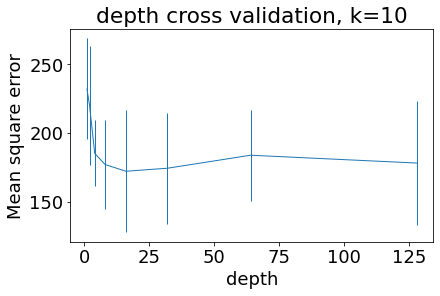

<Figure size 432x288 with 0 Axes>

In [129]:
depths = [1,2,4,8,16,32,64,128]
fold = 10
mean_errors, std_errors = cross_validate_depth(depths, fold, X, y, criterion="mse")
plot_cross_validation(depths, "depth", mean_errors, std_errors, "depth cross validation, k=" + str(fold))


In [130]:
regress(criterion="mse", max_depth=8)

r2 (test) -- reference this 0.18372197885808128
mse (test) -- reference this 233.65642916096633

r2 (train) -- do not use 0.7636393077692585
mse (train) -- do not use 66.06009269084745


RandomForestRegressor(max_depth=8)